# Background construction

This notebook examines the background construction method and errors.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as de
import dedalus.extras.plot_tools as plot_tools
import atmospheres as atmos
import parameters as param
import mpi4py.MPI as MPI
import uuid
%matplotlib notebook

In [2]:
domain, p_bvp = atmos.solve_hydrostatic_pressure(param, np.float64)
p_full, p, a_full, a, heq, N2 = atmos.truncate_background(param, p_bvp)

2017-05-11 11:05:43,169 domain 0/1 DEBUG :: Global coeff shape: [256]
2017-05-11 11:05:43,170 distributor 0/1 DEBUG :: Mesh: []
2017-05-11 11:05:43,175 problems 0/1 DEBUG :: Parsing Eqn 0
2017-05-11 11:05:43,176 problems 0/1 DEBUG ::   Condition: True
2017-05-11 11:05:43,177 problems 0/1 DEBUG ::   LHS string form: dz(pz) + (N2/g)*pz
2017-05-11 11:05:43,178 problems 0/1 DEBUG ::   RHS string form: pz*pz/p/γ
2017-05-11 11:05:43,181 problems 0/1 DEBUG ::   LHS object form: dz(pz) + ((N2*(g**-1))*pz)
2017-05-11 11:05:43,182 problems 0/1 DEBUG ::   RHS object form: ((pz*pz)*(p**-1))*(γ**-1)
2017-05-11 11:05:43,187 problems 0/1 DEBUG ::   L linear form: dz(δpz) + ((N2*(g**-1))*δpz)
2017-05-11 11:05:43,190 problems 0/1 DEBUG ::   dF linear form: ((((pz*pz)*(-1*(p**-2)))*(γ**-1))*δp) + ((((pz*(p**-1))*(γ**-1))*δpz) + (((pz*(p**-1))*(γ**-1))*δpz))
2017-05-11 11:05:43,191 problems 0/1 DEBUG :: Parsing Eqn 1
2017-05-11 11:05:43,192 problems 0/1 DEBUG ::   Condition: True
2017-05-11 11:05:43,193 

<IPython.core.display.Javascript object>


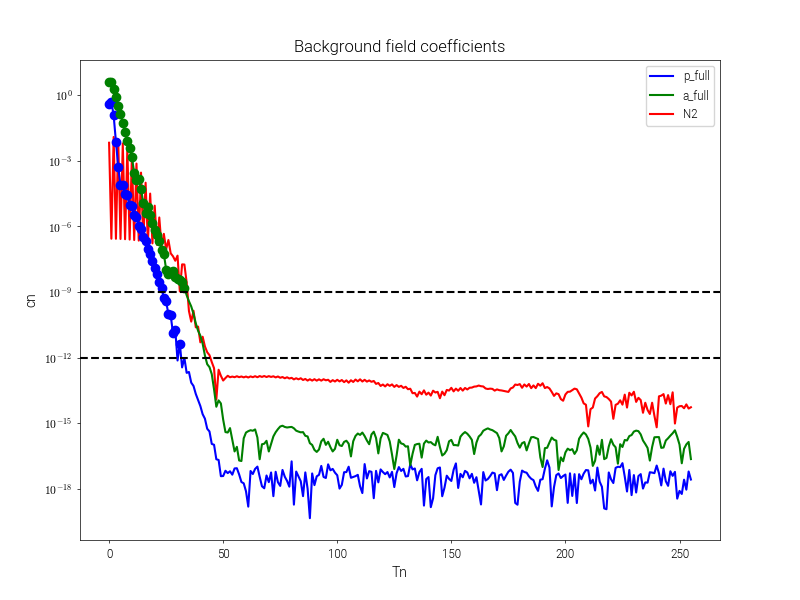

/usr/local/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [3]:
# Plot coefficients
fig, axes = plt.subplots(1, 1)
axes.semilogy(np.abs(p_full['c']), '-', label='p_full')
axes.semilogy(np.abs(a_full['c']), '-', label='a_full')
axes.semilogy(np.abs(N2['c']), '-', label='N2', zorder=0)
axes.set_color_cycle(None)
axes.semilogy(np.abs(p['c']), 'o')
axes.semilogy(np.abs(a['c']), 'o')
axes.axhline(param.pressure_floor, ls='dashed', c='k')
axes.axhline(param.background_floor, ls='dashed', c='k')
axes.set_xlabel('Tn')
axes.set_ylabel('cn')
axes.set_title('Background field coefficients')
axes.legend(loc='upper right')

<IPython.core.display.Javascript object>


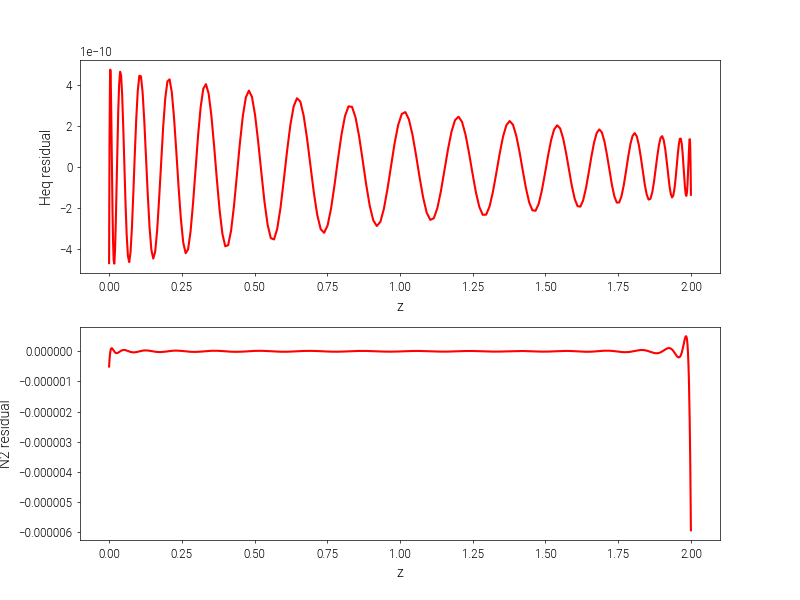

Heq Linf error: 4.7520122856e-10
N2 Linf error: 5.93925650128e-06


In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1)

# Examine hydrostatic equilibrium residual
z = domain.grid(0)
heq.set_scales(1)
ax1.plot(z, heq['g'], '-r')
ax1.set_xlabel('z')
ax1.set_ylabel('Heq residual')
print('Heq Linf error:', np.max(np.abs(heq['g'])))

# Examine buoyancy frequency residual
N2_ref = param.N2_func(z)
N2.set_scales(1)
ax2.plot(z, N2['g']-N2_ref, '-r')
ax2.set_xlabel('z')
ax2.set_ylabel('N2 residual')
print('N2 Linf error:', np.max(np.abs(N2['g']-N2_ref)))

<IPython.core.display.Javascript object>


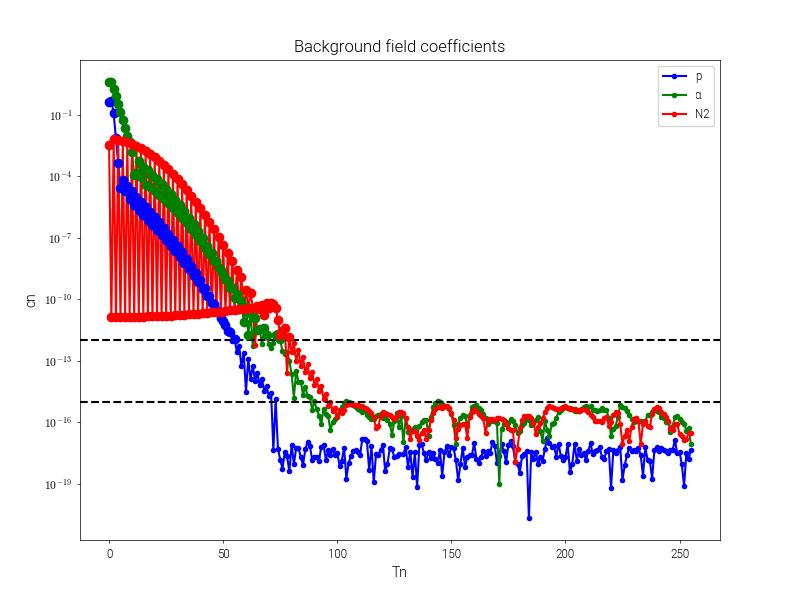

/usr/local/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [5]:
# Filter pressure
p = domain.new_field()
p['c'] = p_bvp['c']
p['c'][np.abs(p['c']) < param.pressure_floor] = 0

# Construct new density and N2
g, γ = param.g, param.γ
pz = p.differentiate('z')
pzz = pz.differentiate('z')
α = ((-g)/pz).evaluate()
N2 = (-g*(pzz/pz - (1/γ)*pz/p)).evaluate()

# Plot coefficients
fig, axes = plt.subplots(1, 1)
axes.semilogy(np.abs(p['c']), '.-', label='p')
axes.semilogy(np.abs(α['c']), '.-', label='α')
axes.semilogy(np.abs(N2['c']), '.-', label='N2')
axes.axhline(param.pressure_floor, ls='dashed', c='k')
axes.axhline(param.background_floor, ls='dashed', c='k')
axes.set_xlabel('Tn')
axes.set_ylabel('cn')
axes.set_title('Background field coefficients')
axes.legend(loc='upper right')

# Cutoff coefficients
p['c'][np.abs(p['c']) < param.background_floor] = 0
α['c'][np.abs(α['c']) < param.background_floor] = 0
N2['c'][np.abs(N2['c']) < param.background_floor] = 0

axes.set_color_cycle(None)
axes.semilogy(np.abs(p['c']), 'o')
axes.semilogy(np.abs(α['c']), 'o')
axes.semilogy(np.abs(N2['c']), 'o')

In [6]:
Hp = (-p / pz).evaluate()
cs2 = (γ * p * α).evaluate()
ωc = (cs2**0.5 / 2 / Hp).evaluate()

In [7]:
fig, axes = plt.subplots(1, 1)
α.set_scales(1)
p.set_scales(1)
Hp.set_scales(1)
cs2.set_scales(1)
axes.plot(z, α['g'], label='α')
axes.plot(z, p['g'], label='p')
axes.plot(z, Hp['g'], label='Hp')
axes.plot(z, cs2['g'], label='cs2')
axes.axhline(0, c='k')
axes.set_xlabel('z')
axes.legend(loc='upper right')

<IPython.core.display.Javascript object>

ValueError: x and y must have same first dimension, but have shapes (512,) and (256,)

In [ ]:
fig, axes = plt.subplots(1, 1)
N2.set_scales(1)
ωc.set_scales(1)
axes.plot(z, N2['g']**0.5, label='N')
axes.plot(z, ωc['g'], label='ωc')
axes.set_xlabel('z')
axes.legend(loc='upper left')
axes.set_ylim(0, None)